# Concepto de `data leakage`
**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ymeza@ubiobio.cl

**Fecha de creación:** Noviembre de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene la explicación de un problema llamado `data leakage` o `fuga de información`.

Esta situación ocurre cuando una o más variables independientes contienen información directa o indirecta de la variable objetivo.

Cuando esto sucede, el modelo **"adivina"** la respuesta en lugar de aprender patrones, lo que se evidencia en **métricas perfectas**.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- `pandas (>=1.1.0)`
- `numpy (2.0.2)`
- `matplotlib (3.10.0)`
- `seaborn (0.13.2)`
- `sklearn (1.6.1)`

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```python
import pandas as pd
print(pd.__version__)
````

In [ ]:
# Descargar el archivo y guardarlo en el entorno
!wget https://raw.githubusercontent.com/JaznaLaProfe/Fundamentos-de-Machine-Learning/master/data/data_jugadores.csv

--2025-11-18 13:38:42--  https://raw.githubusercontent.com/JaznaLaProfe/Fundamentos-de-Machine-Learning/master/data/data_jugadores.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5930 (5.8K) [text/plain]
Saving to: ‘data_jugadores.csv’

data_jugadores.csv  100%[===================>]   5.79K  --.-KB/s    in 0s      

2025-11-18 13:38:42 (63.2 MB/s) - ‘data_jugadores.csv’ saved [5930/5930]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
class Winsorizer(BaseEstimator, TransformerMixin):
  def __init__(self, limits=(0.05, 0.05)):
    self.limits = limits

  def fit(self, X, y=None):
    # Guardar nombres si es DataFrame, si no generar nombres genéricos
    if isinstance(X, pd.DataFrame):
      self.columns_ = X.columns
    else:
      self.columns_ = np.arange(X.shape[1])
    return self

  def transform(self, X):
      X = pd.DataFrame(X, columns=self.columns_)
      for col in self.columns_:
        lower = X[col].quantile(self.limits[0])
        upper = X[col].quantile(1 - self.limits[1])
        X[col] = np.clip(X[col], lower, upper)
      return X.values

  def get_feature_names_out(self, input_features=None):
      if input_features is None:
        return np.array(self.columns_)
      else:
        return np.array(input_features)

def get_correlation(data : pd.DataFrame, candidatas : np.array,
                    visible = True, size = (10,8)) -> np.array:
  """
  Muestra un mapa de calor con las correlaciones entre las variables indicadas

  Parámetros
  ----------
  data : pd.DataFrame
    DataFrame con los datos

  candidatas : np.array
    Nombres de las variables a considerar

  visible : bool
    Si se desea mostrar el mapa de calor
  size : tuple
    Tamaño del mapa de calor

  Retorna
  -------
  np.array matriz de correlaciones
  """
  num_cols = [c for c in candidatas if c in data.columns]
  correlaciones = data[num_cols].corr()
  if visible:
    plt.figure(figsize=size)
    sb.heatmap(correlaciones, annot=True, fmt=".4f", cmap="vlag", center=0)
    plt.title("Heatmap de correlaciones (variables seleccionadas)", fontsize=16, fontweight="bold")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

  return correlaciones

In [ ]:
data = pd.read_csv('data_jugadores.csv')
data.head()

,vida_inicial,daño_recibido,vida_final,jugador_muere
0,84,60,24,0
1,90,70,20,0
2,74,132,-58,1
3,77,78,-1,1
4,119,92,27,0


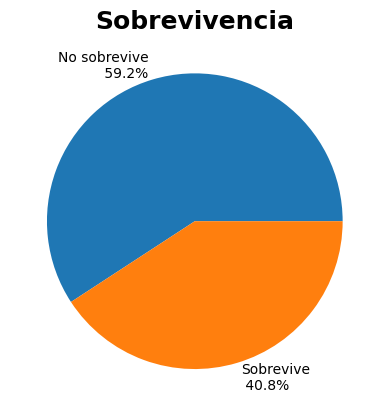

In [ ]:
# Gráfico de torta del porcentaje de supervivencia del jugador
clases = np.array([data[data.jugador_muere == 0.0].shape[0],
                   data[data.jugador_muere == 1.0].shape[0]])

# Leyendas del gráfico.
labels = [ str(round(x * 1.0 / clases.sum() * 100.0, 2)) + '%'  for x in clases ]
labels[0] = 'No sobrevive\n ' + labels[0]
labels[1] = 'Sobrevive\n ' + labels[1]

plt.pie(clases, labels=labels)
plt.title('Sobrevivencia', fontsize=18, fontweight="bold")
plt.show()

In [ ]:
# Define las etiquetas de las clases
etiquetas_target = ["No sobrevive","Sobrevive"]

In [ ]:
X = data.drop(columns=['jugador_muere'])
y = data['jugador_muere']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=29)


In [ ]:
features = ['vida_inicial', 'daño_recibido', 'vida_final']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ("winsor", Winsorizer()),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), features)
])

In [ ]:
pipeline_clasificacion = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', RandomForestClassifier(random_state=29))
])

param_grid = {
    'clasificador__n_estimators': [100, 200],
    'clasificador__max_depth': [5, 10, None]
}

grid = GridSearchCV(
    estimator=pipeline_clasificacion,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=29),
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=29, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('winsor',
                                                                                          Winsorizer()),
                                                                                         ('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['vida_inicial',
                                                                          'daño_recibido',
                                                                          'vida_final'])])),
                                       ('clasificador',
                                        RandomForestClassifier(random_state=29))]),
             n_jobs=-1,
             param_grid={'clasificador__max_depth': [5, 10, None],
                         'clasificador__n_estimators': [100, 200]},
             scoring='f1')

In [ ]:
mejor_modelo = grid.best_estimator_

In [ ]:
# Ahora entrena el mejor modelo
mejor_modelo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('winsor',
                                                                   Winsorizer()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vida_inicial',
                                                   'daño_recibido',
                                                   'vida_final'])])),
                ('clasificador',
                 RandomForestClassifier(max_depth=5, random_state=29))])

In [ ]:
# Realiza las predicciones con el mejor modelo, usando la data de prueba
y_pred = mejor_modelo.predict(X_test)
print(classification_report(y_test, y_pred, target_names=etiquetas_target))

              precision    recall  f1-score   support

No sobrevive       1.00      1.00      1.00        59
   Sobrevive       1.00      1.00      1.00        41

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



🛑 **Métricas perfectas**

Esto es una señal de que el modelo sólo está memorizando y lo que debería pasar es que `debería generalizar`

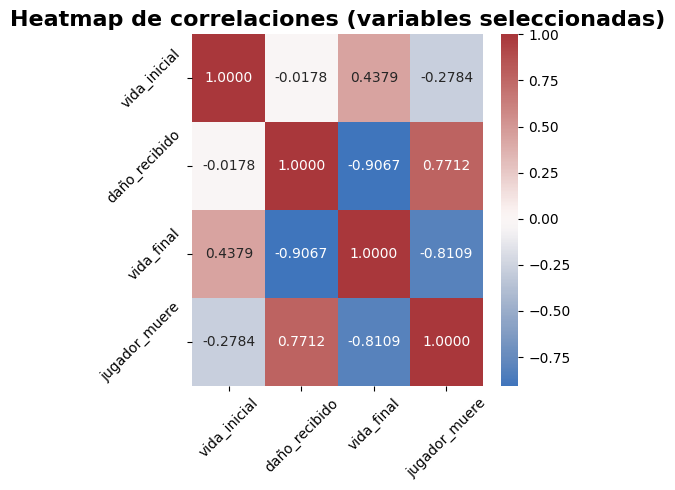

In [ ]:
_ = get_correlation(data, data.columns, size=(5,5))

In [ ]:
X_new = data.drop(columns=['jugador_muere', 'vida_final'])
y = data['jugador_muere']

In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y,
                                                                    test_size=0.2,
                                                                    stratify=y, random_state=29)

In [ ]:
features_without_leakage = ['vida_inicial', 'daño_recibido']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ("winsor", Winsorizer()),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), features_without_leakage)
])

pipeline_clasificacion = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', RandomForestClassifier(random_state=29))
])

grid = GridSearchCV(
    estimator=pipeline_clasificacion,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=29),
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train_new, y_train_new)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=29, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('winsor',
                                                                                          Winsorizer()),
                                                                                         ('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['vida_inicial',
                                                                          'daño_recibido'])])),
                                       ('clasificador',
                                        RandomForestClassifier(random_state=29))]),
             n_jobs=-1,
             param_grid={'clasificador__max_depth': [5, 10, None],
                         'clasificador__n_estimators': [100, 200]},
             scoring='f1')

In [ ]:
# Obtiene el mejor modelos
mejor_modelo = grid.best_estimator_
# Ahora entrena el mejor modelo
mejor_modelo.fit(X_train_new, y_train_new)

y_pred_new = mejor_modelo.predict(X_test_new)
print(classification_report(y_test_new, y_pred_new, target_names = etiquetas_target))

              precision    recall  f1-score   support

No sobrevive       0.97      1.00      0.98        59
   Sobrevive       1.00      0.95      0.97        41

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

